In [148]:
# initial setup
try:
    # settings colab:
    import google.colab
    
    # si usan colab, deben cambiar el token de esta url
    #! mkdir -p ../data
    # los que usan colab deben modificar el token de esta url:
    #! wget -O ../data/properati_2017.csv https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_students_2020/master/M2/CLASE_07_Pandas_2/Data/resultado-de-encuestas-2017-2018.csv?token=AA4GFHO3EKGWGILBCV4BISC6WR6B4
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/base_setup.py"

Running command `conda list`... ok
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
plotly=4.6.0 already installed
Running command `conda install --yes chart-studio=1.1.0`... error
    
PackagesNotFoundError: The following packages are not available from current channels:

  - chart-studio=1.1.0

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





<Figure size 720x576 with 0 Axes>

## Carga Inicial del Dataset

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
import common.matchers as match
import re

In [150]:
# low_memorybool, default True
# Internally process the file in chunks, resulting in lower memory use while parsing, 
# but possibly mixed type inference. To ensure no mixed types either set False, 
# or specify the type with the dtype parameter. 
# Note that the entire file is read into a single DataFrame regardless, 
# use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser).
data = pd.read_csv("./data/properati-fase2.csv", sep = ",", low_memory=False)

## Surface covered

Imputamos superficies faltantes a partir de la colúmna descripción:

In [151]:
na_surfcov_inicio = data["surface_covered_in_m2"].isna().sum()
data.loc[data['surface_covered_in_m2'] == 1, 'surface_covered_in_m2'] = np.nan
data['surface_covered_in_m2'].fillna(data['description'].map(match.match_coveredm2), inplace=True)
na_surfcov_final = data["surface_covered_in_m2"].isna().sum()

print("Total NA surface_covered_in_m2 (0): {0}".format(na_surfcov_inicio))
print("Total NA surface_covered_in_m2 corregidos: {0}".format(na_surfcov_inicio - na_surfcov_final))
print("Total NA surface_covered_in_m2 (1): {0}".format(na_surfcov_final))

Total NA surface_covered_in_m2 (0): 19907
Total NA surface_covered_in_m2 corregidos: 176
Total NA surface_covered_in_m2 (1): 19731


## Surface Total

Volvemos a imputar superficies faltantes, pero esta vez totales, a partir de la colúmna descripción:

In [152]:
na_surftotal_inicio = data["surface_total_in_m2"].isna().sum()
data['surface_total_in_m2'].fillna(data['description'].map(match.match_totalm2), inplace=True)
na_surftotal_final = data["surface_total_in_m2"].isna().sum()

print("Total NA surface_total_in_m2 (0): {0}".format(na_surftotal_inicio))
print("Total NA surface_total_in_m2 corregidos: {0}".format(na_surftotal_inicio - na_surftotal_final))
print("Total NA surface_total_in_m2 (1): {0}".format(na_surftotal_final))

Total NA surface_total_in_m2 (0): 39328
Total NA surface_total_in_m2 corregidos: 1269
Total NA surface_total_in_m2 (1): 38059


## Price

Imputamos precios faltantes a partir de las colúmnas de título y descripción:

In [153]:
na_price_inicio    = data["price"].isna().sum()
na_currency_inicio = data["currency"].isna().sum()

data['tcurrency_tmp'], data['tprice_tmp'] = zip(*data['title'].map(match.match_price_title))
data['dcurrency_tmp'], data['dprice_tmp'] = zip(*data['description'].map(match.match_price_description))

data['price'].fillna(data['tprice_tmp'], inplace=True)
data['price'].fillna(data['dprice_tmp'], inplace=True)
data['currency'].fillna(data['tcurrency_tmp'], inplace=True)
data['currency'].fillna(data['dcurrency_tmp'], inplace=True)

data.drop(['tprice_tmp', 'dprice_tmp', 'tcurrency_tmp', 'dcurrency_tmp'], axis=1, inplace=True)

na_price_final    = data["price"].isna().sum()
na_currency_final = data["currency"].isna().sum()

print("Total NA price+currency (0): ({0}, {1})".format(na_price_inicio, na_currency_inicio))
print("Total NA price+currency corregidos: ({0}, {1})".format(
    na_price_inicio - na_price_final, na_currency_inicio - na_currency_final))
print("Total NA price+currency (1): ({0}, {1})".format(na_price_final, na_currency_final))

Total NA price+currency (0): (20407, 20408)
Total NA price+currency corregidos: (2944, 2944)
Total NA price+currency (1): (17463, 17464)


A continuación, usaremos los valores de las columnas relacionadas para imputar datos faltantes.

Dado que para nuestros posteriores análisis usaremos precios dolarizados, lo primero es asignar un valor representativo al dolar que nos sirva para realizar más imputaciones.

### Estimación valor del Dolar

In [154]:
# Filtramos los que no tengan el precio total en alguna de las 2 monedas
na_price_aprox_mask = data['price_aprox_usd'].isna() & data['price_aprox_local_currency'].isna()
price_aprox  = data.loc[~na_price_aprox_mask, ['price_aprox_usd', 'price_aprox_local_currency']]

# Filtramos los que son 0
na_price_aprox_gt0_mask = (price_aprox['price_aprox_usd'] > 0) & \
    (price_aprox['price_aprox_local_currency'] > 0)
price_aprox  = price_aprox[na_price_aprox_gt0_mask]

# Promediamos
dollar_serie = price_aprox['price_aprox_local_currency'] / price_aprox['price_aprox_usd']
dollar = np.mean(dollar_serie)

print("Valor del Dolar: {0}".format(dollar))

Valor del Dolar: 17.644499988445965


Finalmente, realizamos los cómputos pertinentes:

In [155]:
def fill_from_row(r, dollar):
    # fill prices aprox.
    if pd.notna(r.price):
        if pd.isna(r.price_aprox_usd):
            r.price_aprox_usd = r.price if r.currency == 'USD' else r.price / dollar
        if pd.isna(r.price_aprox_local_currency):
            r.price_aprox_local_currency = r.price if r.currency == 'ARS' else r.price * dollar
    # fill surface_total for apartment
    if r.property_type == 'apartment':
        if pd.isna(r.surface_total_in_m2) and pd.notna(r.surface_covered_in_m2):
            r.surface_total_in_m2 = r.surface_covered_in_m2
    # fill prices m2
    if pd.isna(r.price_usd_per_m2):
        if pd.notna(r.price_aprox_usd) and pd.notna(r.surface_total_in_m2) and r.surface_total_in_m2 > 0:
            r.price_usd_per_m2 = r.price_aprox_usd / r.surface_total_in_m2
        elif pd.notna(r.price_per_m2):
            r.price_usd_per_m2 = r.price_per_m2 / dollar
    if pd.isna(r.price_per_m2):
        if pd.notna(r.price_usd_per_m2):
            r.price_per_m2 = r.price_usd_per_m2 * dollar
        elif pd.notna(r.price_aprox_local_currency) and pd.notna(r.surface_total_in_m2) and r.surface_total_in_m2 > 0:
            r.price_per_m2 = r.price_aprox_local_currency / r.surface_total_in_m2
    # fill surface total
    if pd.isna(r.surface_total_in_m2):
        if pd.notna(r.price_aprox_usd) and pd.notna(r.price_usd_per_m2):
            r.surface_total_in_m2 = r.price_aprox_usd / r.price_usd_per_m2
        elif pd.notna(r.price_aprox_local_currency) and pd.notna(r.price_per_m2):
            r.surface_total_in_m2 = r.price_aprox_local_currency / r.price_per_m2
    return r

na_price_aprox_usd_inico    = data["price_aprox_usd"].isna().sum()
na_price_aprox_local_inicio = data["price_aprox_local_currency"].isna().sum()
na_price_usd_per_m2_inicio  = data['price_usd_per_m2'].isna().sum()
na_price_per_m2_inicio      = data['price_per_m2'].isna().sum()
na_surface_total_inicio     = data['surface_total_in_m2'].isna().sum()

data = data.apply(partial(fill_from_row, dollar=dollar), axis=1)

na_price_aprox_usd_final   = data["price_aprox_usd"].isna().sum()
na_price_aprox_local_final = data["price_aprox_local_currency"].isna().sum()
na_price_usd_per_m2_final  = data['price_usd_per_m2'].isna().sum()
na_price_per_m2_final      = data['price_per_m2'].isna().sum()
na_surface_total_final     = data['surface_total_in_m2'].isna().sum()

print("Total NA price_usd+price_local (0): ({0}, {1})".format(
    na_price_aprox_usd_inico, na_price_aprox_local_inicio))
print("Total NA price_usd+price_local corregidos: ({0}, {1})".format(
    na_price_aprox_usd_inico - na_price_aprox_usd_final,
    na_price_aprox_local_inicio - na_price_aprox_local_final))
print("Total NA price_usd+price_local (1): ({0}, {1})".format(
    na_price_aprox_usd_final, na_price_aprox_local_final))

print("Total NA price_usd_per_m2+price_per_m2 (0): ({0}, {1})".format(
    na_price_usd_per_m2_inicio, na_price_per_m2_inicio))
print("Total NA price_usd_per_m2+price_per_m2 coregidos: ({0}, {1})".format(
    na_price_usd_per_m2_inicio - na_price_usd_per_m2_final,
    na_price_per_m2_inicio - na_price_per_m2_final))
print("Total NA price_usd_per_m2+price_per_m2 (1): ({0}, {1})".format(
    na_price_usd_per_m2_final, na_price_per_m2_final))

print("Total NA surface_total_in_m2 (0): {0}".format(na_surface_total_inicio))
print("Total NA surface_total_in_m2 corregidos: {0}".format(na_surface_total_inicio - na_surface_total_final))
print("Total NA surface_total_in_m2 (1): {0}".format(na_surface_total_final))

Total NA price_usd+price_local (0): (20407, 20407)
Total NA price_usd+price_local corregidos: (2944, 2944)
TotalNA price_usd+price_local (1): (17463, 17463)
Total NA price_usd_per_m2+price_per_m2 (0): (52600, 33559)
Total NA price_usd_per_m2+price_per_m2 coregidos: (26976, 7935)
Total NA price_usd_per_m2+price_per_m2 (1): (25624, 25624)
Total NA surface_total_in_m2 (0): 38059
Total NA surface_total_in_m2 corregidos: 24508
Total NA surface_total_in_m2 (1): 13551


## Outliers

Lo primero que haremos, será renombrar columnas de interés.

In [156]:
new_columns = {
    'Unnamed: 0'                : 'id',
    'surface_total_in_m2'       : 'superficie_total',
    'surface_covered_in_m2'     : 'superficie_cubierta',
    'price_aprox_local_currency': 'precio_ars',
    'price_aprox_usd'           : 'precio_usd',
    'price_per_m2'              : 'precio_m2_ars',
    'price_usd_per_m2'          : 'precio_m2_usd',
}
data.rename(columns=new_columns, inplace=True)

### Gráfica con outliers

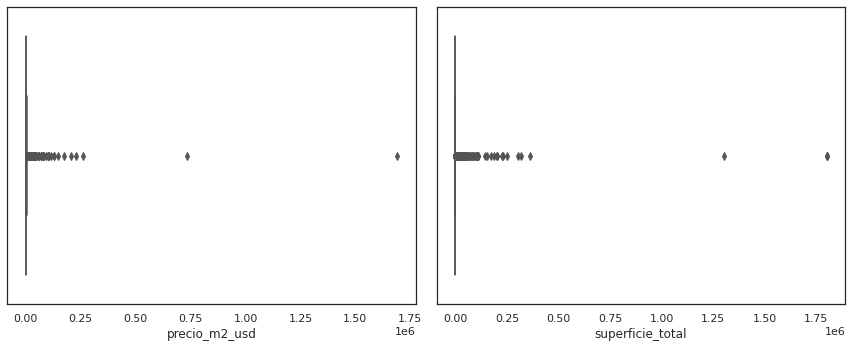

In [157]:
def plot_outliers(dataset):
    sns.set(style="white", palette="muted", color_codes=True)
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sns.boxplot(x=dataset['precio_m2_usd'], ax=axes[0])
    sns.boxplot(x=dataset['superficie_total'], ax=axes[1])
    plt.setp(axes, yticks=[])
    plt.tight_layout()
plot_outliers(data)

En este caso, el tratamiento de los outliers decidimos hacerlo en forma **Manual**.

Básicamente, lo que haremos es por cada outlier detectado chequear la fuente y corregir valores.

### Cómputos Manuales

**NOTA**: Cuando hablamos de *chequear la fuente* es literal. Chequeamos a ojo los campos *title* y *description* del dataset original.

In [158]:
### Función para actualizar superficies
def update(df, id, st, sc=None):
    price   = list(df.loc[df['id'] == id, 'precio_usd'])[0]
    pricem2 = price / st
    if sc is None:
        df.loc[df['id'] == id, ['superficie_total', 'precio_m2_usd']] = [st, pricem2]
    else:
        df.loc[df['id'] == id, ['superficie_total', 'superficie_cubierta', 'precio_m2_usd']] = [st, sc, pricem2]
    if pricem2 > 15000:
        print(id, st, pricem2)

### Función para actualizar precios
def update_price(df, id, price):
    surface = list(df.loc[df['id'] == id, 'superficie_total'])[0]
    pricem2 = price / surface
    df.loc[df['id'] == id, ['precio_usd', 'precio_m2_usd']] = [price, pricem2]
    if pricem2 > 15000:
        print(id, price, pricem2)

### Devuelve la lista de IDs que caen fuera del intervalo (min_price, max_price)
### y que no se encuentren dentro del array keep_if_in
def dropables(df, state_name, max_price, min_price=0, keep_if_in=[]):
    statemask = df['c_estado'] == state_name
    pricemask = (df['precio_m2_usd'] > max_price) if min_price == 0 else \
        (df['precio_m2_usd'] > max_price) | (df['precio_m2_usd'] < min_price)
    dropmask = statemask & pricemask if len(keep_if_in) == 0 else \
        statemask & pricemask & ~df['id'].isin(keep_if_in)
    return [] if len(df) == 0 else list(df[dropmask]['id'])

########################################################################################
## La idea es acumular todos los "dropables" en este array para eliminarlos todos juntos
## al final.
trash = []
########################################################################################
############ precio_usd <= precio_m2_usd
############ [10528, 41061, 41574, 47586, 49274, 53324, 55181, 67746]
trash += [10528, 41574, 47586, 49274, 53324, 55181]
update(data, 41061, 1240)
update(data, 67746, 1300, 220)
############ precio_usd == 1 => 241
update_price(data, 263, 240000)
update_price(data, 7587, 250000)
update(data, 7587, 780)
update_price(data, 9121, 270000)
update(data, 9121, 594)
update_price(data, 12918, 120000)
update(data, 12918, 65)
update_price(data, 55630, 120000)
update(data, 55630, 169)
precio_usd_eq_1 = list(data.loc[data['precio_usd'] == 1, 'id'])
trash += list(filter(lambda x: not (x in [263, 7587, 9121, 12918, 55630]), precio_usd_eq_1))
############ precio_usd < 5000 => 121
update_price(data, 2246, 299200)
update_price(data, 2281, 118800)
update_price(data, 2283, 111800)
update_price(data, 3971, 88000)
update_price(data, 2278, 77000)
precio_usd_lt_5000 = list(data.loc[data['precio_usd'] < 5000, 'id'])
trash += list(filter(lambda x: not (x in [2246, 2281, 2283, 3971, 2278]), precio_usd_lt_5000))
############ TUCUMAN
update_price(data, 1766, 3000000  / dollar)
update_price(data, 61349, 2500000 / dollar)
update_price(data, 61353, 500000  / dollar)
update_price(data, 61354, 3300000 / dollar)
update_price(data, 61355, 1300000 / dollar)
update_price(data, 62548, 1600000 / dollar)
update_price(data, 83818, 1473295 / dollar)
trash += dropables(data, 'Tucumán', 10000) + [1791, 1815, 1736, 1767, 1780, 84347]
############ RIO NEGRO
update_price(data, 1922, 360000)
update_price(data, 23339, 1785000 / dollar)
update(data, 23339, 61.65, 51.81)
update_price(data, 27106, 450000)
update(data, 33039, 132, 132)
update(data, 52268, 71)
update(data, 107137, 320)
update(data, 898, 200)
update(data, 10364, 693)
update(data, 15127, 2239)
update(data, 15906, 43)
update(data, 17064, 98.71, 98.71)
update(data, 17073, 35.47, 35.47)
update(data, 19118, 262, 45)
update(data, 21562, 182)
update(data, 19401, 3093, 201)
############ MISIONES
update(data, 14374, 200)
update(data, 63886, 400)
update(data, 38798, 107)
update(data, 38817, 432)
update(data, 41204, 375, 85)
update(data, 48617, 364.8)
update(data, 59127, 124.2)
trash += dropables(data, 'Misiones', 3000, 110, [
    14374, 63886, 38798, 38817, 41204, 48617, 59127,
])
############ SANTA FE
update_price(data, 25565, 690000 / dollar)
update_price(data, 6720, 2545000 / dollar)
update(data, 6720, 58.91)
update(data, 4917, 1032)
update(data, 102379, 76, 36)
trash += dropables(data, 'Santa Fe', 5000, 100, [
    25565, 102379, 4917, 9230, 25295, 30992, 100514,
])
############ SALTA
update(data, 11239, 600)
update_price(data, 25163, 2800000 / dollar)
update_price(data, 25343, 2850000 / dollar)
update_price(data, 25561, 1100000 / dollar)
update_price(data, 26619, 2500000 / dollar)
update_price(data, 26737, 2800000 / dollar)
update_price(data, 26738, 2600000 / dollar)
update(data, 59441, 600, 130)
update(data, 59442, 800, 110)
trash += dropables(data, 'Salta', 3000, 100, [
    11239, 25163, 25343, 25561, 26619, 26737, 26738, 59441, 59442,
])
############ MENDOZA
update_price(data, 24831, 700000 / dollar)
update_price(data, 26874, 1200000 / dollar)
trash += dropables(data, 'Mendoza', 3000, 0, [24831, 26874])
############ ENTRE RIOS
update_price(data, 26831, 1250000 / dollar)
update_price(data, 108996, 1500000 / dollar)
############ NEUQUEN
update(data, 39054, 150, 93.76)
trash += dropables(data, 'Neuquén', 3000, 100, [39054, 61373, 61521, 65398])
############ CORDOBA
update_price(data, 39978, 165000)
update_price(data, 91428, 147000)
update(data, 91428, 800, 200)
update_price(data, 91289, 160000)
update(data, 91289, 770, 190)
update(data, 115705, 6250, 200)
update(data, 115819, 245.43, 170)
update(data, 57742, 800, 190)
trash += dropables(data, 'Córdoba', 5000, 100, [
    72354, 39978, 91428, 91289, 115705, 115819, 57742,
])
############ SAN LUIS
update_price(data, 25030, 4000000 / dollar)
update_price(data, 25049, 2300000 / dollar)
update_price(data, 25051, 2600000 / dollar)
update(data, 25051, 300, 201)
update_price(data, 25353, 2800000 / dollar)
update_price(data, 25357, 700000 / dollar)
update_price(data, 25710, 1550000 / dollar)
update_price(data, 37212, 2300000 / dollar)
update_price(data, 40946, 1700000 / dollar)
update_price(data, 40947, 1600000 / dollar)
update_price(data, 51777, 1700000 / dollar)
update_price(data, 25074, 450000 / dollar)
update_price(data, 25981, 650000 / dollar)
update_price(data, 25982, 750000 / dollar)
update_price(data, 40610, 1500000 / dollar)
update_price(data, 89902, 250000 / dollar)
update_price(data, 92251, 135000 / dollar)
update(data, 92251, 85.40, 65.9)
update_price(data, 92284, 135000 / dollar)
update(data, 92284, 83.95, 66.57)
update_price(data, 92267, 135000 / dollar)
update(data, 92267, 85.40, 65.9)
############ BUENOS AIRES INTERIOR
update(data, 41655, 4600, 300)
update(data, 45533, 1000)
update(data, 60838, 870)
update_price(data, 79134, 174230)
update_price(data, 79124, 120620)
update_price(data, 70817, 96000)
trash += dropables(data, 'Buenos Aires Interior', 3000, 100, [
    41655, 45533, 60838, 79134, 79124, 70817, 93429,
])
############ BUENOS AIRES COSTA ATLANTICA
update_price(data, 1424, 180000)
update(data, 24589, 73, 16)
update(data, 11096, 130)
update(data, 58234, 71.89, 54.7)
update(data, 97096, 87)
trash += [12625, 24580, 35966, 37615, 41539, 43221, 49246, 50460, 67898, 94838, 120124]
############ BUENOS AIRES ZONA SUR
update(data, 78243, 90.22)
update(data, 58948, 132, 92)
update(data, 58398, 236)
update(data, 94342, 188.68)
update(data, 74913, 72.4)
update(data, 74957, 72.4)
update(data, 95574, 381, 220)
update(data, 75360, 123, 87)
update(data, 58062, 9718)
update(data, 12306, 7600, 70)
update(data, 73523, 112)
update(data, 7104, 235, 175)
update(data, 7665, 1200)
update(data, 8263, 229)
update(data, 8501, 850)
update(data, 8606, 850)
update(data, 9228, 145)
update(data, 9422, 216.5)
update(data, 10365, 1800)
update(data, 10368, 135)
update(data, 10991, 139)
update(data, 11632, 134)
update(data, 13439, 228.94)
update(data, 13966, 300)
update(data, 15842, 850)
update(data, 15916, 664)
update(data, 15918, 59)
update(data, 15919, 50)
update(data, 16265, 280)
update(data, 16685, 570)
update(data, 16686, 201)
update(data, 17039, 335)
update(data, 19422, 286)
update(data, 20226, 228)
update(data, 20850, 83.72, 65.72)
update(data, 21054, 2850)
update(data, 22055, 800)
update(data, 22056, 300)
update(data, 22853, 325)
update(data, 23431, 225)
update(data, 23452, 50)
update(data, 23519, 200)
update(data, 24007, 450)
update(data, 24021, 83.46, 78.51)
update(data, 27393, 420)
update(data, 27992, 900)
update(data, 28076, 52)
update(data, 28452, 55)
update(data, 28588, 211)
update(data, 30433, 235)
update(data, 30517, 952)
update(data, 31033, 1100)
update(data, 32250, 2750)
update(data, 32391, 283.5)
update(data, 33046, 420)
update(data, 33493, 1380)
update(data, 35522, 225)
update(data, 35555, 809)
update(data, 35949, 1630)
trash += dropables(data, 'Bs.As. G.B.A. Zona Sur', 4000, 100, [
    78243, 58948, 58398, 94342, 74913, 74957, 95574, 75360, 58062, 12306, 73523,
    7104, 7665, 8263, 8501, 8606, 9228, 9422, 10365, 10368, 10991, 11632, 13439, 
    13966, 15842, 15916, 15918, 15919, 16265, 16685, 16686, 17039, 19422, 20226,
    20850, 21054, 22055, 22056, 22853, 23431, 23452, 23519, 24007, 24021, 27393,
    27992, 28076, 28452, 28588, 30433, 30517, 31033, 32250, 32391, 33046, 33493,
    35522, 35555, 35949
])
############ BUENOS AIRES ZONA NORTE
update_price(data, 47089, 1000000 / dollar)
update(data, 77033, 802)
update(data, 76557, 505.05)
update(data, 74973, 1162)
update(data, 74697, 466)
update(data, 77012, 410)
update(data, 74850, 1004)
update(data, 112387, 396, 150)
update(data, 110930, 1265.95)
update(data, 17686, 210)
update(data, 110926, 1213.03)
update(data, 10756, 55, 13)
update(data, 610, 225)
update(data, 628, 54)
update(data, 74950, 156)
update(data, 75586, 1005)
update(data, 112362, 1190, 150)
update(data, 76705, 1065)
update(data, 29604, 37)
update(data, 45629, 875)
update(data, 74959, 190)
update(data, 40964, 100)
update(data, 40970, 100)
update(data, 40973, 100)
update(data, 108732, 289.22)
trash += dropables(data, 'Bs.As. G.B.A. Zona Norte', 10000, 100, [
    77033, 76557, 74973, 74697, 77012, 74850, 112387, 110930, 17686, 110926,
    10756, 610, 628, 74950, 75586, 112362, 76705, 29604, 45629, 74959, 40964,
    40970, 40973, 63819, 108732,
])
############ BUENOS AIRES ZONA OESTE
update_price(data, 116491, 62000)
update_price(data, 114131, 120000)
update_price(data, 26356, 980000 / dollar)
update(data, 16797, 303.1)
update(data, 14887, 233.82)
update(data, 14546, 300)
update(data, 14532, 160)
update(data, 5401, 100)
update(data, 267, 360)
update(data, 34083, 132)
update(data, 293, 210)
update(data, 4346, 300)
update(data, 6639, 340)
update(data, 7034, 1250)
trash += dropables(data, 'Bs.As. G.B.A. Zona Oeste', 5000, 100, [
    116491, 114131, 26356, 16797, 14887, 14546, 14532, 5401, 267, 34083, 293,
    4346, 6639, 7034,
])
############ CAPITAL FEDERAL
update_price(data, 2573, 915000)
update_price(data, 2511, 279000)
update_price(data, 25694, 716900  / dollar)
update_price(data, 25119, 1744000 / dollar)
update(data, 17026, 158.33, 135.16)
update(data, 18927, 90)
update(data, 17947, 107.3)
update(data, 17397, 100)
update(data, 17026, 158.33)
update(data, 10842, 165)
update(data, 10843, 165)
update(data, 10844, 165)
update(data, 10846, 165)
update(data, 10847, 165)
update(data, 10850, 165)
update(data, 10851, 165)
update(data, 10852, 165)
update(data, 10853, 165)
update(data, 9866, 40)
update(data, 5886, 56.2, 51.7)
update(data, 7375, 190)
update(data, 8384, 61)
update(data, 8390, 191)
update(data, 8397, 45)
update(data, 8924, 110)
update(data, 5371, 25)
update(data, 21531, 165)
update(data, 506, 230)
update(data, 842, 24)
update(data, 990, 700)
update(data, 5156, 233)
update(data, 5481, 80)
update(data, 7101, 178)
update(data, 7668, 183)
update(data, 8502, 164)
update(data, 8513, 218.92)
update(data, 8627, 82)
update(data, 9602, 101)
update(data, 9629, 504)
update(data, 10271, 68)
update(data, 10278, 23.4)
update(data, 10285, 110)
update(data, 10346, 170, 140)
update(data, 10369, 260)
update(data, 10930, 245, 98)
update(data, 10935, 240)
update(data, 11259, 49)
update(data, 12667, 334.88)
update(data, 13158, 720)
update(data, 13236, 304)
update(data, 13242, 32)
update(data, 13582, 505, 42)
update(data, 13585, 565, 27)
update(data, 13587, 333, 295)
update(data, 13977, 96.64, 87.65)
update(data, 14011, 305, 27)
update(data, 14012, 305, 27)
update(data, 14013, 445, 32)
update(data, 16573, 90, 30)
update(data, 17272, 478)
update(data, 20821, 44)
update(data, 20827, 63.20)
update(data, 27237, 351,76)
update(data, 27311, 242)
update(data, 28062, 36.62, 36.62)
update(data, 28067, 38.88)
update(data, 30424, 177)
update(data, 30765, 259)
update(data, 31922, 20)
update(data, 32323, 30)
update(data, 32347, 103, 82.15)
update(data, 32348, 92, 68.65)
update(data, 32349, 54, 43)
update(data, 32350, 86.68, 50.3)
update(data, 32853, 103)
update(data, 34705, 582, 432)
update(data, 35566, 654)
trash += dropables(data, 'Capital Federal', 15000, 250, [
    2573, 2511, 25694, 25119, 17026, 18927, 17947, 17397, 17026, 10842, 10843, 10844,
    10846, 10847, 10850, 10851, 10852, 10853, 9866, 5886, 7375, 8384, 8390, 8397, 8924,
    5371, 21531, 506, 842, 5156, 5481, 7101, 7668, 8502, 8513, 8627, 9602, 9629, 10271,
    10278, 10285, 10346, 10369, 10930, 10935, 11259, 12667, 13158, 13236, 13242, 13582,
    13585, 13587, 13977, 14011, 14012, 14013, 16573, 17272, 20821, 20827, 27237, 27311,
    28062, 28067, 30424, 30765, 31922, 32323, 32347, 32348, 32349, 32350, 32853, 34705,
    35566, 
])
########################################################################################
if len(trash) > 0:
    dropables_mask = data['id'].isin(trash)
    if dropables_mask.sum() > 0:
        data = data[~dropables_mask]

**NOTA IMPORTANTE**: El estudio *manual* de outliers nos quedó sin terminar. Habría que revisar en profundidad **Zona Sur** y **Capital Federal** (aunque si vemos arriba, corregimos bastante registros de Capital).

### Gráfica mejorada

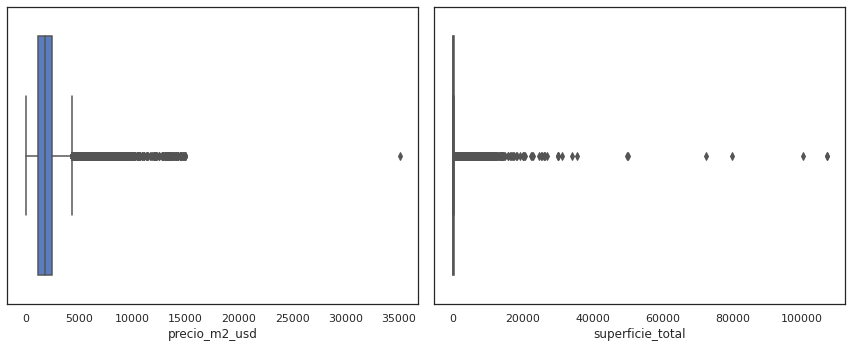

In [159]:
plot_outliers(data)

Finalmente, nos vamos a deshacer de todos los registros que tengan el precio por m2.

In [160]:
data = data[data['precio_m2_usd'].notna()]

También, de los outliers restantes. Primero, aquellos relacionados al precio:

In [161]:
precio_m2_Q1 = data['precio_m2_usd'].quantile(0.25)
precio_m2_Q3 = data['precio_m2_usd'].quantile(0.75)
precio_m2_IQR = precio_m2_Q3 - precio_m2_Q1
precio_m2_min = precio_m2_Q1 - 1.5 * precio_m2_IQR
precio_m2_max = precio_m2_Q3 + 1.5 * precio_m2_IQR
data = data[(data['precio_m2_usd'] > precio_m2_min) & (data['precio_m2_usd'] < precio_m2_max)]

Y por último, de aquellos relacionados a la superficie total.

In [162]:
suptotal_Q1 = data['superficie_total'].quantile(0.25)
suptotal_Q3 = data['superficie_total'].quantile(0.75)
suptotal_IQR = suptotal_Q3 - suptotal_Q1
suptotal_min = suptotal_Q1 - 1.5 * suptotal_IQR
suptotal_max = suptotal_Q3 + 1.5 * suptotal_IQR
data = data[(data['superficie_total'] > suptotal_min) & (data['superficie_total'] < suptotal_max)]

### Gráfica sin outliers

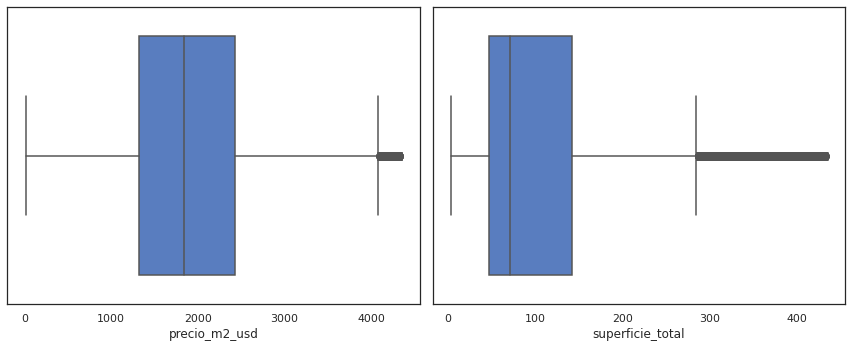

In [163]:
plot_outliers(data)

## Visualización

In [164]:
counts = data.groupby('c_estado').size().sort_values(ascending=False)
counts

c_estado
Capital Federal                 24596
Bs.As. G.B.A. Zona Norte        17091
Bs.As. G.B.A. Zona Sur           7325
Buenos Aires Costa Atlántica     6973
Bs.As. G.B.A. Zona Oeste         6181
Córdoba                          5211
Santa Fe                         4764
Buenos Aires Interior            1049
Mendoza                           398
Corrientes                        294
Río Negro                         281
Neuquén                           242
Misiones                          213
Tucumán                           182
Chubut                            114
San Luis                          103
Entre Ríos                         83
Salta                              74
Formosa                            29
Tierra Del Fuego                   27
Chaco                              27
La Pampa                           14
Santa Cruz                         10
Catamarca                           7
San Juan                            5
Jujuy                               3
La 

Vemos que todo Buenos Aires, Córdoba y Santa Fé siguen siendo los lugares con más anuncios publicados (a pesar de la limpieza) por lo que volvemos a dividir el gráfico de barras en 2 gráficos para observar la distribución de anuncios final a lo largo del país.

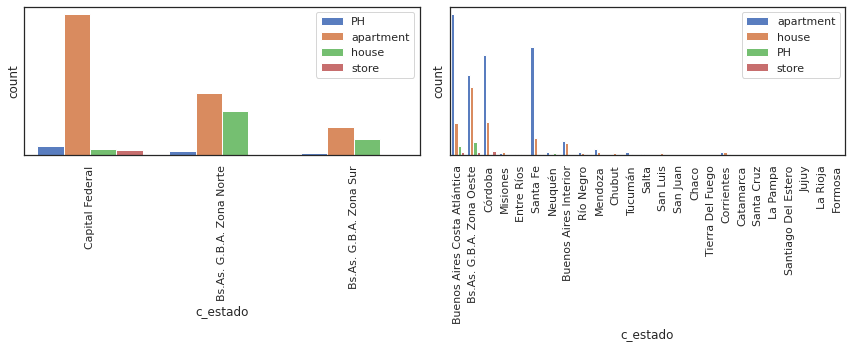

In [165]:
top_estados = counts.head(3).index.values
top_regions = data['c_estado'].isin(top_estados)

_, axes   = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
countplt1 = sns.countplot(x="c_estado",
                          hue="property_type",
                          data=data[top_regions],
                          ax=axes[0])
countplt2 = sns.countplot(x="c_estado",
                          hue="property_type",
                          data=data[~top_regions],
                          ax=axes[1])

countplt1.set_xticklabels(countplt1.get_xticklabels(), rotation=90)
countplt2.set_xticklabels(countplt2.get_xticklabels(), rotation=90)

countplt1.legend(loc='upper right')
countplt2.legend(loc='upper right')

plt.setp(axes, yticks=[])
plt.tight_layout()

A continuación visualizamos la distribución de los precios por estado:

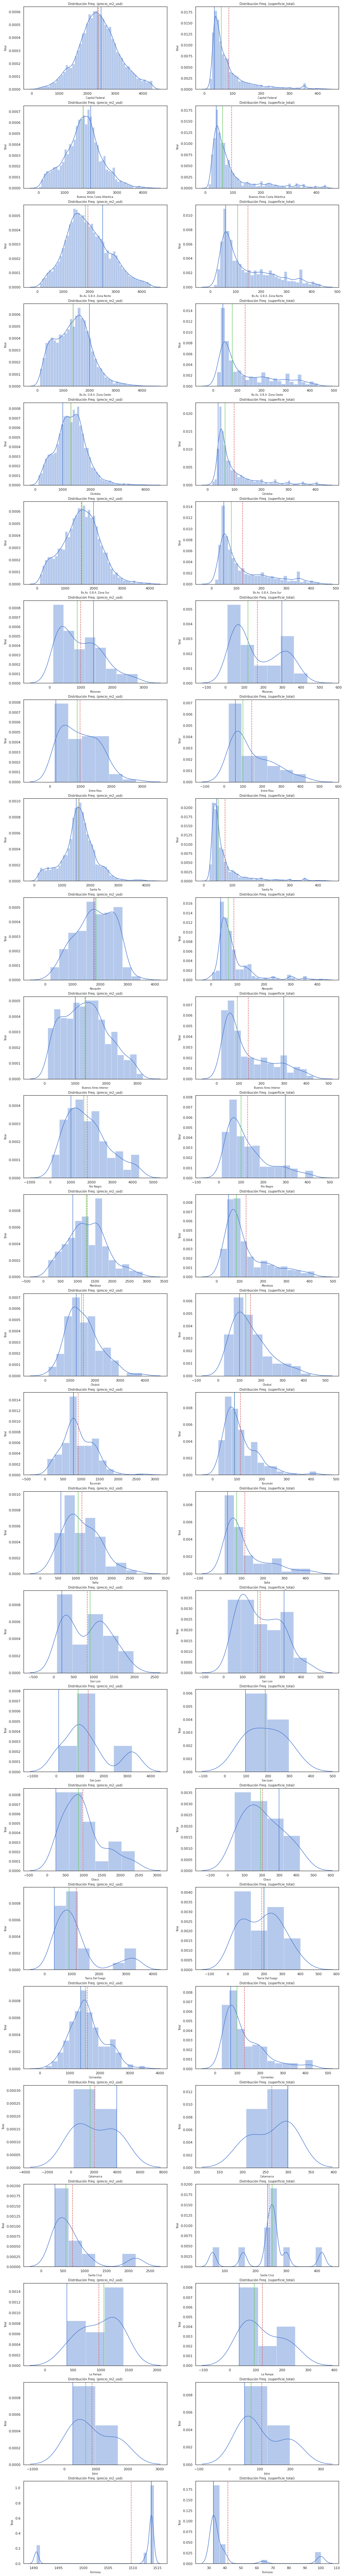

In [166]:
states = []
for s in data['c_estado'].unique():
    ds = data[data['c_estado'] == s]
    pvar = round(np.nan_to_num(ds['precio_m2_usd'].var()))
    svar = round(np.nan_to_num(ds['superficie_total'].var()))
    if pvar > 0 or svar > 0:
        states.append(s)

_, axes = plt.subplots(nrows=len(states), ncols=2, figsize=(18, 150))
for idx, state in enumerate(states):
    ds = data[data['c_estado'] == state]
    # plot - precio
    precio_mean   = ds['precio_m2_usd'].mean()
    precio_median = ds['precio_m2_usd'].median()
    precio_mode   = ds['precio_m2_usd'].mode().values[0]
    sns.distplot(ds['precio_m2_usd'], hist=True, ax=axes[idx][0])
    pvar = round(np.nan_to_num(ds['precio_m2_usd'].var()))
    if pvar > 0:
        axes[idx][0].set_title('Distribución Freq. (precio_m2_usd)', fontsize=10)
        axes[idx][0].set_xlabel(state, fontsize=8)
        axes[idx][0].set_ylabel('Total', fontsize=8)
        axes[idx][0].axvline(precio_mean,   color='r', linestyle='--')
        axes[idx][0].axvline(precio_median, color='g', linestyle='-')
        axes[idx][0].axvline(precio_mode,   color='b', linestyle='-')
    # plot - superficie
    sup_mean   = ds['superficie_total'].mean()
    sup_median = ds['superficie_total'].median()
    sup_mode   = ds['superficie_total'].mode().values[0]
    sns.distplot(ds['superficie_total'], hist=True, ax=axes[idx][1])
    svar = round(np.nan_to_num(ds['superficie_total'].var()))
    if svar > 0:
        axes[idx][1].set_title('Distribución Freq. (superficie_total)', fontsize=10)
        axes[idx][1].set_xlabel(state, fontsize=8)
        axes[idx][1].set_ylabel('Total', fontsize=8)
        axes[idx][1].axvline(sup_mean,   color='r', linestyle='--')
        axes[idx][1].axvline(sup_median, color='g', linestyle='-')
        axes[idx][1].axvline(sup_mode,   color='b', linestyle='-')
plt.show()

En los gráficos anteriores, podemos ver la distribución por zona respecto de las medidas de tendencia central de 2 de las variables de interés: *precio_m2_usd* y *superficie_total* (la línea azul es la moda, la línea verde es la mediana y la línea punteada roja es la media).

A pesar de la limpieza, la distribución de precios de algunas zonas como Formosa o Catamarca tienen poco sentido.

Finalmente, vemos a continuación unos boxplots para tener una idea de como quedaron las variables luego del procesamiento:

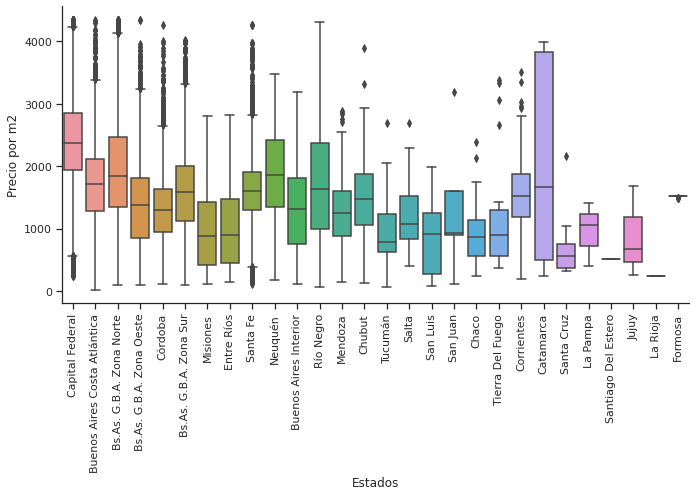

In [167]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("c_estado", 'precio_m2_usd', data=data, kind="box", height=5, aspect=2)
    g.set_xticklabels(rotation=90)
    g.set_axis_labels("Estados", 'Precio por m2')

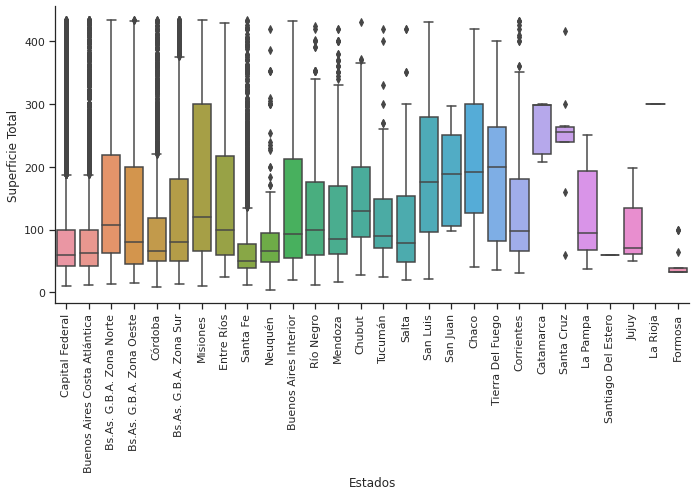

In [168]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("c_estado", 'superficie_total', data=data, kind="box", height=5, aspect=2)
    g.set_xticklabels(rotation=90)
    g.set_axis_labels("Estados", 'Superficie Total')

In [169]:
data.to_csv('./data/properati-fase3.csv', sep=',', index=False)